In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from datetime import datetime
from osgeo import gdal, osr

In [2]:
file_C01_blue = '/home/adriano/cap408-goes-lecture/data/goes/goes16/ABI/B01/2025/01/01/S10635300_202501011300.nc' # Canal Azul (Blue)
file_C02_red  = '/home/adriano/cap408-goes-lecture/data/goes/goes16/ABI/B02/2025/01/01/S10635316_202501011300.nc' # Canal Vermelho (Red)
file_C03_veggie = '/home/adriano/cap408-goes-lecture/data/goes/goes16/ABI/B03/2025/01/01/S10635302_202501011300.nc' # Canal "Veggie" (NIR)


In [11]:
def read_data(filename, lat_min, lat_max, lon_min, lon_max, res_pixel_in_km):
    """Efficiently reads, reprojects, and clips GOES ABI data."""
    gdal.UseExceptions()
    abi_ds = gdal.Open(f"NETCDF:{filename}:CMI")
    dqf_ds = gdal.Open(f"NETCDF:{filename}:DQF")
    
    source_proj = osr.SpatialReference()
    source_proj.ImportFromWkt(abi_ds.GetProjection())
    
    target_proj = osr.SpatialReference()
    target_proj.ImportFromEPSG(4326)
    
    abi_band = abi_ds.GetRasterBand(1)
    scale_factor, offset, fill_value = abi_band.GetScale(), abi_band.GetOffset(), abi_band.GetNoDataValue()
    
    res_in_degrees = res_pixel_in_km / 111.32
    
    warp_params = {'format': 'MEM', 'srcSRS': source_proj, 'dstSRS': target_proj,
                   'outputBounds': (lon_min, lat_min, lon_max, lat_max), 'xRes': res_in_degrees, 'yRes': res_in_degrees,
                   'outputType': gdal.GDT_Float32, 'srcNodata': fill_value, 'dstNodata': np.nan,
                   'resampleAlg': gdal.GRA_NearestNeighbour}
                   
    crop_abi_ds = gdal.Warp('', abi_ds, **warp_params)
    crop_dqf_ds = gdal.Warp('', dqf_ds, **warp_params)
    
    crop_abi_data = crop_abi_ds.GetRasterBand(1).ReadAsArray()
    crop_dqf_data = crop_dqf_ds.GetRasterBand(1).ReadAsArray()
    
    calibrated_data = crop_abi_data * scale_factor + offset
    final_data = np.where(crop_dqf_data > 0, np.nan, calibrated_data)
    
    lats = np.linspace(lat_max, lat_min, final_data.shape[0])
    lons = np.linspace(lon_min, lon_max, final_data.shape[1])
    
    # Clean up datasets from memory
    abi_ds, dqf_ds, crop_abi_ds, crop_dqf_ds = None, None, None, None
    
    return final_data, lats, lons

In [12]:
# =============================================================================
# --- 1. DATA LOADING AND PREPARATION ---
# =============================================================================
# Domain and resolution
lat_min, lat_max, lon_min, lon_max = -60, 15, -90, -30
res_km = 2.0 # Output resolution in km

# Load the data for each channel
R, lats, lons = read_data(file_C02_red, lat_min, lat_max, lon_min, lon_max, res_km)
B, _, _ = read_data(file_C01_blue, lat_min, lat_max, lon_min, lon_max, res_km)
V, _, _ = read_data(file_C03_veggie, lat_min, lat_max, lon_min, lon_max, res_km)

# Synthesize the Green channel (G)
# The GOES satellite does not have a green channel; it is generated from other channels.
# Standard formula: G = 0.45*R + 0.10*B + 0.45*V
G = 0.45 * R + 0.10 * B + 0.45 * V

# Apply gamma correction and normalize to the [0, 1] range
gamma = 2.2
R = np.clip(R, 0, 1)**(1/gamma)
G = np.clip(G, 0, 1)**(1/gamma)
B = np.clip(B, 0, 1)**(1/gamma)

# Stack the channels to create the RGB image
rgb = np.dstack((R, G, B))

Warning 1: Unhandled X/Y axis unit rad. SRS will ignore axis unit and be likely wrong.
Warning 1: Unhandled X/Y axis unit rad. SRS will ignore axis unit and be likely wrong.
Warning 1: Unhandled X/Y axis unit rad. SRS will ignore axis unit and be likely wrong.
Warning 1: Unhandled X/Y axis unit rad. SRS will ignore axis unit and be likely wrong.
Warning 1: Unhandled X/Y axis unit rad. SRS will ignore axis unit and be likely wrong.
Warning 1: Unhandled X/Y axis unit rad. SRS will ignore axis unit and be likely wrong.


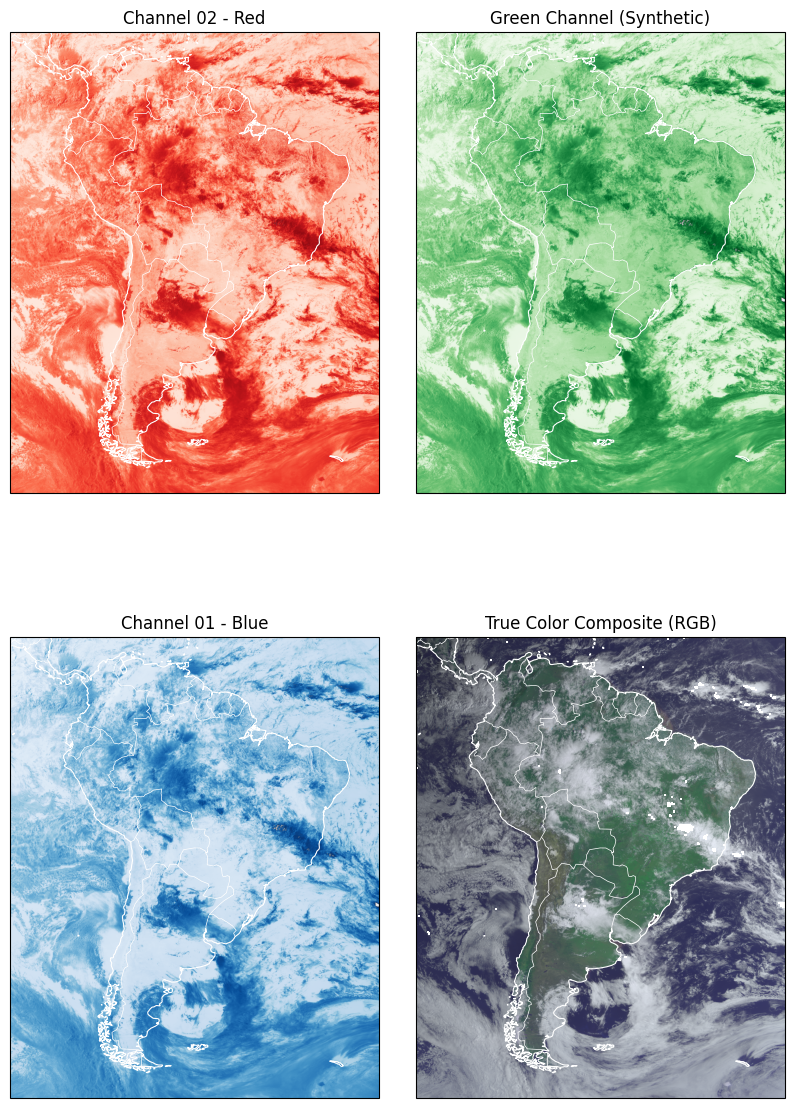

In [13]:
# =============================================================================
# --- 2. PLOT GRID CREATION (2X2 MATRIX) ---
# =============================================================================
# Date and time for the title (example)
datetime_fmt = datetime.strptime("2025-01-01T13:00:00.000Z", '%Y-%m-%dT%H:%M:%S.%fZ')
proj = ccrs.PlateCarree()

# Create the figure and axes (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(10, 15), subplot_kw={'projection': proj})

# Flatten the axes array for easy iteration
axes = axes.ravel()

# --- Plot 1: Red Channel ---
axes[0].set_title('Channel 02 - Red')
axes[0].imshow(R, origin='upper', cmap='Reds', extent=[lon_min, lon_max, lat_min, lat_max], transform=proj)

# --- Plot 2: Green Channel (Synthetic) ---
axes[1].set_title('Green Channel (Synthetic)')
axes[1].imshow(G, origin='upper', cmap='Greens', extent=[lon_min, lon_max, lat_min, lat_max], transform=proj)

# --- Plot 3: Blue Channel ---
axes[2].set_title('Channel 01 - Blue')
axes[2].imshow(B, origin='upper', cmap='Blues', extent=[lon_min, lon_max, lat_min, lat_max], transform=proj)

# --- Plot 4: True Color (RGB) ---
axes[3].set_title('True Color Composite (RGB)')
axes[3].imshow(rgb, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max], transform=proj)

# Add coastlines and borders to all plots
for ax in axes:
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
    ax.coastlines(resolution='50m', color='white', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='white')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()